<a href="https://colab.research.google.com/github/LauraSchellekens/TM10007_-private_-group/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment template

In [20]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git
!pip install sklearn numpy matplotlib


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [0]:
# General packages not sure anymore what I'm actually using lol
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import impute
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import feature_selection

In [22]:
# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')


X = data.drop('label', axis=1) # All data without column 'label'
Y = data['label'] 
Y.replace(('AD', 'CN'), (1, 0), inplace=True) # convert AD and CN to 1 and 0


The number of samples: 855
The number of columns: 268


In [23]:
data

,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,hf_skewness,hf_std,label,logf_energy_sigma1,logf_energy_sigma10,logf_energy_sigma5,logf_entropy_sigma1,logf_entropy_sigma10,logf_entropy_sigma5,logf_kurtosis_sigma1,logf_kurtosis_sigma10,logf_kurtosis_sigma5,logf_max_sigma1,logf_max_sigma10,logf_max_sigma5,logf_mean_sigma1,logf_mean_sigma10,logf_mean_sigma5,logf_median_sigma1,logf_median_sigma10,logf_median_sigma5,logf_min_sigma1,logf_min_sigma10,logf_min_sigma5,logf_peak_sigma1,logf_peak_sigma10,logf_peak_sigma5,logf_quartile_range_sigma1,logf_quartile_range_sigma10,logf_quartile_range_sigma5,...,tf_NGTDM_Coarseness,tf_NGTDM_Complexity,tf_NGTDM_Contrast,tf_NGTDM_Strength,"vf_Frangi_edge_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_002_S_0413_bl_0,5403.229408,4.679203,2.392463,2.040475,1.375697,1.487644,-0.062859,429,0.364471,2.103334,-1.481394,0.455533,1,6395.491754,9940.032401,14622.897328,4.072445,5.204894,4.841280,3.774545,-0.108664,2.224809,0.498333,0.746542,0.785263,-0.007726,-0.069990,-0.029403,-0.000075,-0.068204,0.008103,-0.632451,-1.092715,-1.402496,1304,210,608,0.153782,0.627844,0.457846,...,0.020347,0.022628,0.000556,0.018271,2.374306e-14,4.104987,7.559967,6.673826e-09,1.741492e-09,1.299429e-09,1.734096e-10,514,1.519472e-09,6.500416e-09,2.307441,1.554520e-09,2.374306e-14,4.104987,7.559967,6.673826e-09,1.741492e-09,1.299429e-09,1.734096e-10,514,1.519472e-09,6.500416e-09,2.307441,1.554520e-09,2.446356e-17,3.969563,4.283295,1.930203e-09,4.762307e-10,3.147900e-10,1.195016e-10,8,4.503026e-10,1.810702e-09,2.003542,4.207831e-10
0_002_S_0559_bl_0,922.459760,4.772376,1.709731,1.437500,0.863074,0.940709,-0.247543,412,0.347258,1.685042,-1.222797,0.377850,1,8432.620063,5549.455518,12050.086848,4.076190,5.228020,4.830720,3.252139,-0.730229,0.348783,0.483188,0.412527,0.529344,-0.001275,-0.127039,-0.054140,0.000178,-0.145082,-0.044920,-0.578344,-0.633490,-0.828795,906,229,317,0.189966,0.455902,0.447878,...,0.010227,0.039959,0.001927,0.009183,6.260213e-15,4.471662,3.674709,2.910256e-09,8.867658e-10,7.190769e-10,4.342644e-11,421,8.276855e-10,2.866830e-09,1.605653,7.019460e-10,6.260213e-15,4.471662,3.674709,2.910256e-09,8.867658e-10,7.190769e-10,4.342644e-11,421,8.276855e-10,2.866830e-09,1.605653,7.019460e-10,2.058198e-17,4.401233,2.048344,1.189167e-09,3.678934e-10,3.325169e-10,6.933179e-13,11,4.3

In [24]:
# split into train (70%) and test (30%) set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(598, 267) (598,)
(257, 267) (257,)


In [25]:
# Preprocessing: drop feature if too many missing values

X_train = X_train.replace(0, np.NaN)                                    # replace 0 with NaN
missing_per_feature_train = X_train.isnull().sum()                      # gives the amount of missing values (NaN) per feature
pct_null_train = missing_per_feature_train / len(X_train)               # gives percentage of missing values per feature
missing_features_train = pct_null_train[pct_null_train > 0.40].index    # gives features with more than 40% missing values
X_train.drop(missing_features_train, axis=1, inplace=True)              # remove feature if more than 40% missing values

X_test = X_test.replace(0, np.NaN)                                      # replace 0 with NaN
missing_per_feature_test = X_test.isnull().sum()                        # gives the amount of missing values (NaN) per feature
pct_null_test = missing_per_feature_test / len(X_test)                  # gives percentage of missing values per feature
missing_features_test = pct_null_test[pct_null_train > 0.40].index      # gives features with more than 40% missing values
X_test.drop(missing_features_test, axis=1, inplace=True)                # remove feature if more than 40% missing values

missing_per_feature_max_train = max(X_train.isnull().sum())             # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features
missing_per_feature_max_test = max(X_test.isnull().sum())               # gives the maximum amount of missing values (NaN) per feature AFTER dropping incomplete features

print(missing_per_feature_max)
print (X_train.shape, y_train.shape)

104
(598, 261) (598,)


In [26]:
X_train

,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,hf_skewness,hf_std,logf_energy_sigma1,logf_energy_sigma10,logf_energy_sigma5,logf_entropy_sigma1,logf_entropy_sigma10,logf_entropy_sigma5,logf_kurtosis_sigma1,logf_kurtosis_sigma10,logf_kurtosis_sigma5,logf_max_sigma1,logf_max_sigma10,logf_max_sigma5,logf_mean_sigma1,logf_mean_sigma10,logf_mean_sigma5,logf_median_sigma1,logf_median_sigma10,logf_median_sigma5,logf_min_sigma1,logf_min_sigma10,logf_min_sigma5,logf_peak_sigma1,logf_peak_sigma10,logf_peak_sigma5,logf_quartile_range_sigma1,logf_quartile_range_sigma10,logf_quartile_range_sigma5,logf_range_sigma1,...,tf_NGTDM_Coarseness,tf_NGTDM_Complexity,tf_NGTDM_Contrast,tf_NGTDM_Strength,"vf_Frangi_edge_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_031_S_0618_bl_0,611.099745,4.197536,4.649123,1.358926,0.969957,0.992872,0.304271,464,0.246695,1.054656,-1.378785,0.237619,8288.175208,1961.033367,6290.653843,4.044788,5.421189,5.235231,3.548791,-1.234356,0.321686,0.440162,0.390410,0.653895,-0.000815,-0.012331,0.017649,0.003061,0.034707,0.047575,-0.579782,-0.558879,-1.023062,1002,238,252,0.181250,0.532689,0.476966,1.019945,...,0.065690,0.007176,3.279586e-05,0.064072,4.777175e-15,4.696696,1.040138,2.674338e-09,7.925016e-10,6.628760e-10,NaN,680,9.311099e-10,2.674338e-09,1.112570,7.055754e-10,4.777175e-15,4.696696,1.040138,2.674338e-09,7.925016e-10,6.628760e-10,NaN,680,9.311099e-10,2.674338e-09,1.112570,7.055754e-10,1.387464e-16,4.149862e+00,0.366463,2.149768e-09,6.079535e-10,2.770627e-10,NaN,54,1.037364e-09,2.149768e-09,1.045312e+00,6.791238e-10
0_057_S_5292_bl_0,8587.807873,4.398140,1.816204,2.297433,1.603748,1.595296,0.873323,327,0.321590,1.424109,-0.187956,0.296417,18381.701797,5110.746298,9284.895292,3.456349,4.846343,4.531916,8.985242,0.133807,0.948201,0.774606,0.917005,0.776492,-0.004938,-0.028495,-0.008867,0.000785,0.009026,-0.003216,-1.023885,-0.868726,-0.882478,1354,374,787,0.110533,0.615377,0.436544,1.798491,...,2.580708,0.000239,1.320319e-07,1.441648,1.241009e-14,4.541449,1.834204,4.856125e-09,1.562324e-09,1.230823e-09,6.213512e-11,292,1.404106e-09,4.793990e-09,1.310801,1.178234e-09,1.241009e-14,4.541449,1.834204,4.856125e-09,1.562324e-09,1.230823e-09,6.213512e-11,292,1.404106e-09,4.793990e-09,1.310801,1.178234e-09,7.877798e-19,5.654493e-13,-3.000000,4.437848e-10,4.437848e-10,4.437848e-10,4.437

In [28]:
# Preprocessing:  impute missing values (fill missing)

imputer = impute.SimpleImputer(strategy='mean')       # imputer with mean 
X_train_imp = imputer.fit_transform(X_train)          # impute  
X_train_imp = pd.DataFrame(data=X_train_imp, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df

X_test_imp = imputer.fit_transform(X_test)            # impute  
X_test_imp = pd.DataFrame(data=X_test_imp, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df

type(X_train_imp)


pandas.core.frame.DataFrame

In [9]:
# Preprocessing: scaling either standard or robust (removes median and scales data according to quantile range) 

scaler = preprocessing.StandardScaler()
scaler.fit_transform(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)        # scaling the training data

scaler.fit_transform(X_test_imp)
X_test_scaled = scaler.transform(X_test_imp)          # scaling the test data

X_train_scaled = pd.DataFrame(data=X_train_scaled, index=[X_train.index], columns=[X_train.columns])  # turn created np.array back to pandas df
X_test_scaled = pd.DataFrame(data=X_test_scaled, index=[X_test.index], columns=[X_test.columns])      # turn created np.array back to pandas df
X_train_scaled


,hf_energy,hf_entropy,hf_kurtosis,hf_max,hf_mean,hf_median,hf_min,hf_peak,hf_quartile_range,hf_range,hf_skewness,hf_std,logf_energy_sigma1,logf_energy_sigma10,logf_energy_sigma5,logf_entropy_sigma1,logf_entropy_sigma10,logf_entropy_sigma5,logf_kurtosis_sigma1,logf_kurtosis_sigma10,logf_kurtosis_sigma5,logf_max_sigma1,logf_max_sigma10,logf_max_sigma5,logf_mean_sigma1,logf_mean_sigma10,logf_mean_sigma5,logf_median_sigma1,logf_median_sigma10,logf_median_sigma5,logf_min_sigma1,logf_min_sigma10,logf_min_sigma5,logf_peak_sigma1,logf_peak_sigma10,logf_peak_sigma5,logf_quartile_range_sigma1,logf_quartile_range_sigma10,logf_quartile_range_sigma5,logf_range_sigma1,...,tf_NGTDM_Coarseness,tf_NGTDM_Complexity,tf_NGTDM_Contrast,tf_NGTDM_Strength,"vf_Frangi_edge_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_full_std_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_energy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_entropy_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_kurtosis_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_max_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_mean_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_median_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_min_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_peak_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_quartile_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_range_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_skewness_SR(1.0, 10.0)_SS2.0","vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0_016_S_4951_bl_0,-0.719031,-0.909330,1.154024,-1.107647,-0.623774,-0.848259,-0.116501,0.809749,-0.786577,-0.703569,-0.549390,-0.899954,1.185304,0.979229,1.040595,-0.532945,-0.083564,-0.023940,0.391729,0.564671,0.674187,1.305460,0.170276,0.999450,0.061710,-0.101330,-0.131085,0.768058,0.634165,0.085306,-0.906315,-2.173080,-2.504130,0.755009,0.005445,0.080904,0.202538,0.201913,-0.014682,1.169341,...,-0.256815,-0.526225,-0.501322,-0.340900,-0.798752,-0.282113,0.398880,-1.147781,-1.060157,-0.865663,0.005562,-0.355376,-1.312619,-1.164831,0.353987,-1.270069,-0.798752,-0.282113,0.398880,-1.147781,-1.060157,-0.865663,0.005562,-0.355376,-1.312619,-1.164831,0.353987,-1.270069,-2.866839e-01,-1.636150,-0.746712,-5.335674e-01,5.303513e-01,8.429464e-01,2.522533e+00,-0.602957,-0.770463,-1.019300,-2.365588e-16,-8.001193e-01
0_070_S_4692_bl_0,-0.389037,1.408672,-1.730164,-1.109961,-2.172345,-2.687260,-1.163744,-0.190834,2.268110,0.452342,2.584361,1.427340,-0.112856,0.719722,0.678685,-1.011106,-1.081089,-1.717509,0.137389,1.146689,1.178186,-1.267555,-0.734212,-0.563576,-1.642979,0.343472,0.224732,-0.442320,0.382314,-0.149614,0.380561,-0.040949,-0.057569,2.526586,2.865334,2.802329,-1.340099,-1.341413,-1.722246,-0.782485,...,-0.256815,2.552740,3.593720,-0.452560,0.158003,0.021748,-0.779417,-0.315377,0.050526,0.124046,1.464142,0.432601,0.066329,-0.378177,-0.770364,-0.249902,0.158003,0.021748,-0.779417,-0.315377,0.050526,0.124046,1.464142,0.432601,0.066329,-0.378177,-0.770364,-0.249902,2.378709e+00,0.931285,-0.262225,1.628764e+00,1.758513e+00,1.410841e+00,9.918634e-01,0.45250

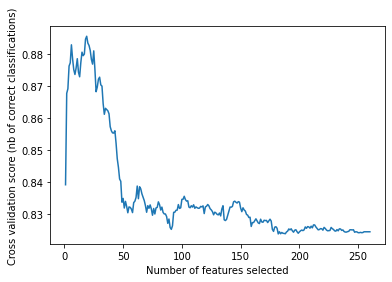

In [19]:
# Code for feature selection
'''
First determine the best amount of features
'''

# Create the RFE object and compute a cross-validated score.
svc = svm.SVC(kernel="linear")
X= X_train_scaled.iloc[:,1:261]
y= y_train

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(X, y)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [17]:
# Code for feature selection
'''
With the amount of features desired known, find the best performing features
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
 
#apply SelectKBest class to extract top ... best features
bestfeatures = SelectKBest(score_func= f_classif, k=32) # k= number of desired features
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(32,'Score'))  #print ... best features 

                                            Specs       Score
0                                   (hf_entropy,)  427.427213
217                          (tf_LBP_std_R3_P12,)  334.302007
1                                  (hf_kurtosis,)  334.233558
7                            (hf_quartile_range,)  319.800005
10                                      (hf_std,)  290.500809
110                  (tf_GLRLM_ShortRunEmphasis,)  236.059742
99                  (tf_GLRLM_GrayLevelVariance,)  231.468762
98   (tf_GLRLM_GrayLevelNonUniformityNormalized,)  226.803663
112      (tf_GLRLM_ShortRunLowGrayLevelEmphasis,)  225.566689
72              (phasef_phasesym_entropy_WL3_N5,)  202.821690
133                      (tf_Gabor_0.05A0.0skew,)  180.773030
108                     (tf_GLRLM_RunPercentage,)  173.191494
5                                       (hf_min,)  160.641596
101                   (tf_GLRLM_LongRunEmphasis,)  158.384793
202                     (tf_LBP_kurtosis_R3_P12,)  154.227872
75      

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [207 210 211 212] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
